# Tensorflow2 KeyNotes
### == Convolutional Neural Network based Fourier Transform (TF2) 
### Instructions

These serial notebooks are intended to record my practicing and keynotes with deep learning in the framework of TensorFlow 2. Within these notebooks, I demonstrate the networks with specific examples and my personal interpretations.  You can find instructions in each section for each project.  Feel free to refer to it if is helpful for your work. 

In this notebook, I will demonstrate examples of audio signal analsis in python, and signal processing by using neural networks. The conventional audio feature extraction based methods + dense neural network    

use of convolutional neural networks to simulate fast Fourier transform/and inverse fast Fourier transform for discrete-time signal analysis. Compared with similar results obtained from dense neural networks (previous notebook TF2_DNN_Based_Fast_Fourier_Transform.ipynb), the proposed convolutional neural network architecture shows a significant improvement in model accuracy. To illustrate this experiment, the following contents are included in this notebook:

1. Forward Fourier Transform based on Convolutional neural network.
2. Inverse Fourier Transform based on Convolutional neural network.

### Code by Hao, Zhao, Nov, 2020.



### Import the tensorflow library

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0



###  Load the external libraries

In [2]:
import numpy as np
# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.fftpack
import time
import cmath

from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout,Conv1D,SimpleRNN,AveragePooling1D,Flatten, Conv1D,Flatten,Reshape

---------------------------------------------------------------------------
##  *1. Data generation*
----------------------------------------------------------------------------

###  (1) Generate the random series and corresponding FFT transform counterparts for training of Neural Network

First, we generate some random time series as input to the Fast Fourier Transform (FFT). The corresponding output of the FFT is used as the target of the neural network. Unlike the use of complex (valued) neural networks, the naive approach combining the complex and imaginary outputs of the FFT into an array has been used for regression of neural network training.

In [3]:
number_arrays = 10000
length_series = 256

input_series          = np.random.normal(0,1,(number_arrays,length_series))
fft_tansfrom_series   = scipy.fftpack.fft(input_series)


## generate and encode the training and test set using a naive approach to handel the complex number in Neural network
train_input = input_series[:np.int(number_arrays*0.8),:]
test_input  = input_series[np.int(number_arrays*0.8):,:]

train_target_real =  fft_tansfrom_series.real[:np.int(number_arrays*0.8),:]
train_target_imag =  fft_tansfrom_series.imag[:np.int(number_arrays*0.8),:]

test_target_real =  fft_tansfrom_series.real[np.int(number_arrays*0.8):,:]
test_target_imag =  fft_tansfrom_series.imag[np.int(number_arrays*0.8):,:]

# prepare the target series (sort the real part and imaginary part into one array)
train_target = np.zeros((train_target_real.shape[0],length_series*2))
train_target[:,0::2] =  train_target_real
train_target[:,1::2] =  train_target_imag 

test_target  = np.zeros((test_target_real.shape[0],length_series*2))
test_target[:,0::2] =  test_target_real
test_target[:,1::2] =  test_target_imag 

# print train set's size
print('=== input of training set size: {}  === '.format(train_input.shape))
print('=== target of training set size: {} === '.format(train_target.shape))
print('=== input of test set size: {}  === '.format(test_input.shape))
print('=== target of test set size: {} === '.format(test_target.shape))

=== input of training set size: (8000, 256)  === 
=== target of training set size: (8000, 512) === 
=== input of test set size: (2000, 256)  === 
=== target of test set size: (2000, 512) === 


### (2) Generate a synthetic time series for validation of derived neural network models

Apart from the generated random training set and test set, a synthetic time series with designated frequency components have been generated for the validation test of the final derived convolutional neural network model.  

=== validation used dataset size: (256,)  === 


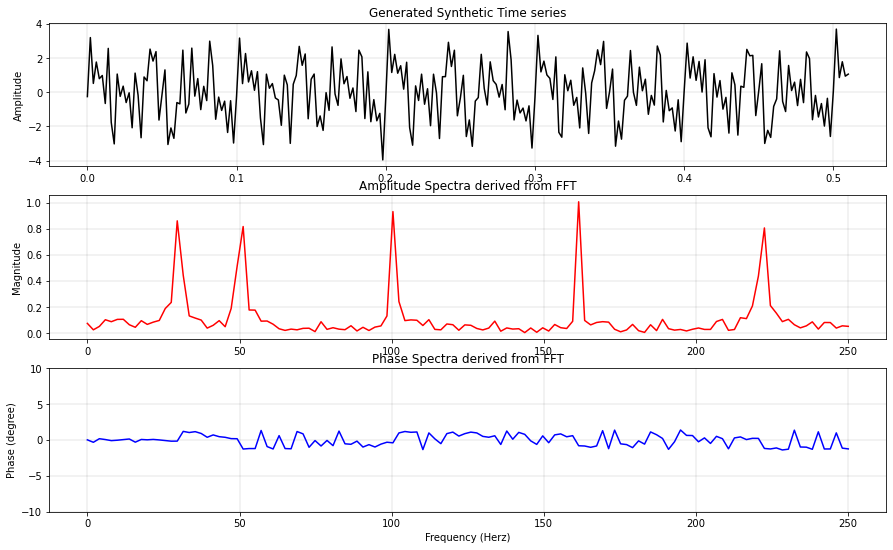

In [4]:
# Generate a synthetic time series based on sinusoid signals
dt,t_min,t_max = 0.002,0,(256-1)*0.002 
t              = np.linspace(t_min,t_max,int((t_max-t_min)/dt+1))
f0,f1,f2,f3,f4 = 30,50,100,160,220
SNR            = 10    
syn_sig        = np.sin((2*np.pi*f0)*t)  + np.sin((2*np.pi*f1)*t) + np.sin((2*np.pi*f2)*t) + np.sin((2*np.pi*f3)*t) + np.sin((2*np.pi*f4)*t)   
syn_data       = syn_sig + np.random.normal(0,10**(-SNR/20),len(syn_sig))

# FFT of generated signal
N=256
fft_syn_data = scipy.fftpack.fft(syn_data[0:N])
# 0 to Fs/2, Fs = 1/Ts
xf = np.linspace(0.0, 1.0/(2*dt), int(N/2))

# print data set's size
print('=== validation used dataset size: {}  === '.format(syn_data.shape))

# plot the generated synthetic time series and corresponding amplitude/phase spectra
plt.figure(figsize=(15, 9))
plt.subplot(311)
plt.plot(t[0:N],syn_data[0:N],'k') 
#plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Generated Synthetic Time series')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.subplot(312)
plt.plot(xf, 2.0/N * np.abs(fft_syn_data[:N//2]),'r')
plt.ylabel('Magnitude')
plt.title('Amplitude Spectra derived from FFT')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.subplot(313)
plt.plot(xf, 2.0/N * np.angle(fft_syn_data[:N//2],deg=True),'b')
plt.xlabel('Frequency (Herz)')
plt.ylabel('Phase (degree)')
plt.ylim(-10, 10)
plt.title('Phase Spectra derived from FFT')
plt.grid(color='k', linestyle='-', linewidth=0.1)


-------------------------------------------------------------
## *2. Forward Fourier Transform based on Convolutional neural network* 
-------------------------------------------------------------

In the previous notebook (TF2_DNN_based_Fast_Fourier_Transform.ipynb), I demonstrated the feasibility of using a dense neural network to simulate the Fourier transform. In the current notebook, I further demonstrated by switching to a 1D convolutional neural network, we can further implement a more accurate model by using the convolutional neural network architecture.

### Build the convolutional neural network 

In [5]:
model = Sequential([Reshape(target_shape=(length_series,1), input_shape=(length_series,)),
                    Conv1D(filters=16, kernel_size=3, activation='relu'),
                    Flatten(),
                    Dense(length_series*2)
                    ])

model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 256, 1)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 254, 16)           64        
_________________________________________________________________
flatten (Flatten)            (None, 4064)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2081280   
Total params: 2,081,344
Trainable params: 2,081,344
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [6]:
start      = time.time()
history    = model.fit(train_input,train_target,batch_size=32,epochs=100,validation_split=0.20,verbose=0)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))

Training completed in : 15809.69ms


### Display of training and validation losses in the network training


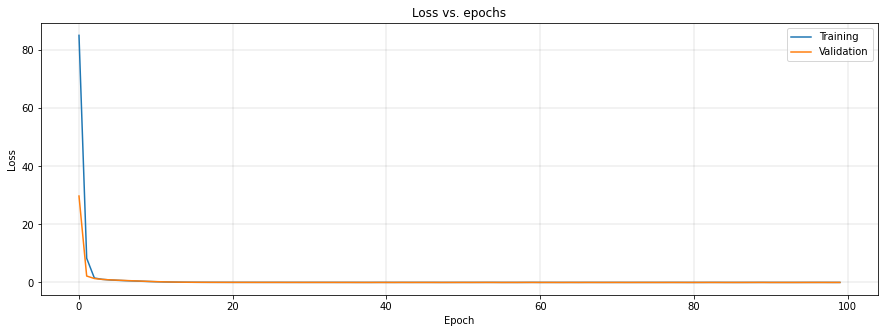

In [7]:
plt.figure(2,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Check the validation error on the test set


In [8]:
evaluation_losses = model.evaluate(test_input,test_target,verbose=0)
print()
print(" ========= test dataset has mse loss : {} ".format(evaluation_losses[0]))


 ========= test dataset has mse loss : 0.018090449273586273 



### Comparison of the FFT and CNN based Fourier Transform on generated random series


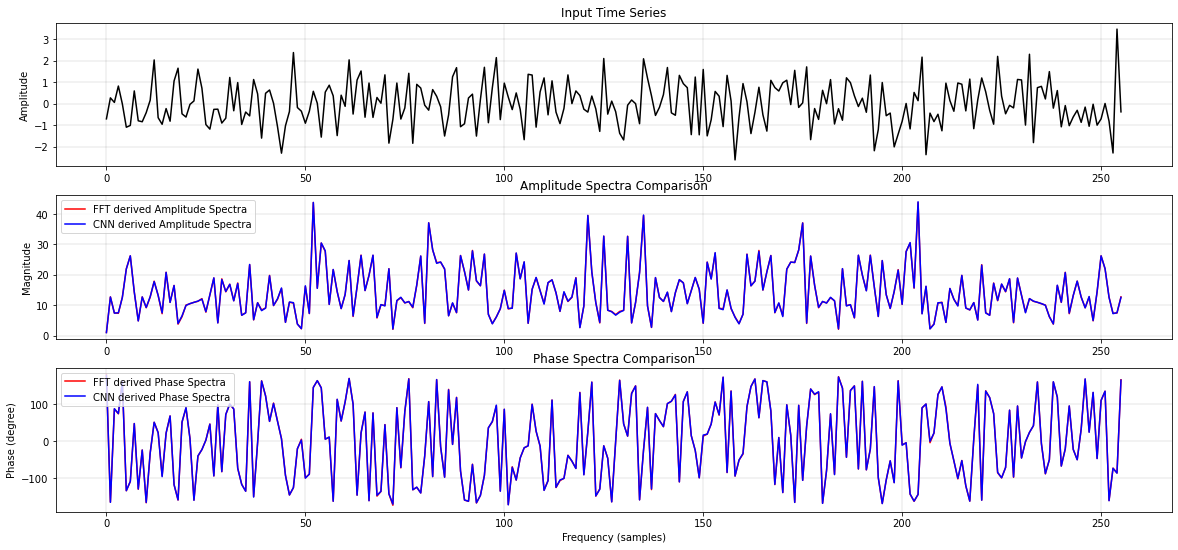

In [9]:
#Prediction with trainned network
cnn_predictions = model.predict(test_input)
cnn_err         = cnn_predictions - test_target

# make the comparison on selected time series
qc_series_id = 10

plt.figure(2,figsize=(20, 9))
plt.subplot(311)
plt.title('Input Time Series')
plt.plot(test_input[qc_series_id,:],'k')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.ylabel('Amplitude')

plt.subplot(312)
plt.title('Amplitude Spectra Comparison')
plt.plot(np.abs(test_target[qc_series_id,0::2]+1j*test_target[qc_series_id,1::2]),'r',label='FFT derived Amplitude Spectra')
plt.plot(np.abs(cnn_predictions[qc_series_id,0::2]+1j*cnn_predictions[qc_series_id,1::2]),'b',label='CNN derived Amplitude Spectra')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='upper left')
# plt.xlabel('Frequency (samples)')
plt.ylabel('Magnitude')

plt.subplot(313)
plt.title('Phase Spectra Comparison')
plt.plot(np.angle(test_target[qc_series_id,0::2]+1j*test_target[qc_series_id,1::2],deg=True),'r',label='FFT derived Phase Spectra')
plt.plot(np.angle(cnn_predictions[qc_series_id,0::2]+1j*cnn_predictions[qc_series_id,1::2],deg=True),'b',label='CNN derived Phase Spectra')
plt.xlabel('Frequency (samples)')
plt.ylabel('Phase (degree)')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='upper left')


### Comparison of the FFT and CNN based Fourier Transform on generated synthetic time series

In [10]:
# FFT transform based on trainned convolutional neural network
cnn_predictions_syn = model.predict(syn_data[np.newaxis,...])
cnn_FFT_syn         = cnn_predictions_syn[:,0::2]+1j*cnn_predictions_syn[:,1::2]
cnn_FFT_syn         = np.squeeze(cnn_FFT_syn,axis=0)

### Compare the DNN based Fourier Transform with FFT

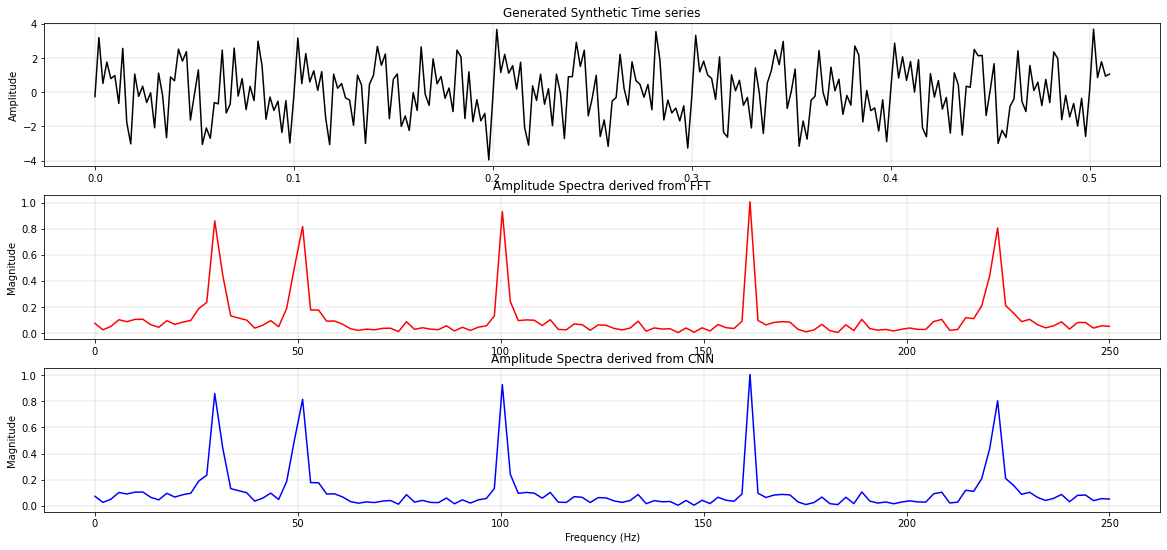

In [11]:

# (1) plot the Amplitude Spectrum Comparison
plt.figure(4,figsize=(20, 9))
plt.subplot(311)
plt.plot(t[0:N],syn_data[0:N],'k') 
# plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Generated Synthetic Time series')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.subplot(312)
plt.plot(xf, 2.0/N * np.abs(fft_syn_data[:N//2]),'r')
plt.ylabel('Magnitude')
plt.title('Amplitude Spectra derived from FFT')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.subplot(313)
plt.plot(xf, 2.0/N * np.abs(cnn_FFT_syn[:N//2]),'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Amplitude Spectra derived from CNN')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()




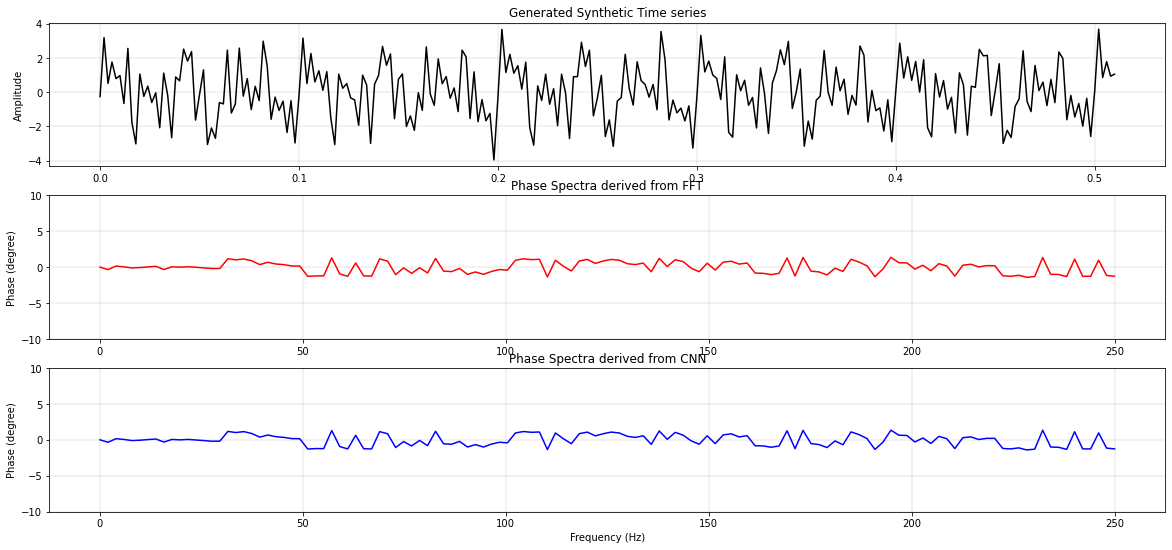

In [12]:
# (2) plot the Phase Spectrum Comparison
# plot the generated series
plt.figure(5,figsize=(20, 9))
plt.subplot(311)
plt.plot(t[0:N],syn_data[0:N],'k') 
# plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Generated Synthetic Time series')
plt.grid(color='k', linestyle='-', linewidth=0.1)

# 0 to Fs/2, Fs = 1/Ts
xf = np.linspace(0.0, 1.0/(2*dt), int(N/2))
plt.subplot(312)
plt.plot(xf, 2.0/N * np.angle(fft_syn_data[:N//2],deg=True),'r')
plt.ylabel('Phase (degree)')
plt.ylim(-10, 10)
plt.title('Phase Spectra derived from FFT')
plt.grid(color='k', linestyle='-', linewidth=0.1)

dnn_predictions_syn = model.predict(syn_data[np.newaxis,...])
dnn_FFT_syn         = dnn_predictions_syn[:,0::2]+1j*cnn_predictions_syn[:,1::2]
dnn_FFT_syn         = np.squeeze(dnn_FFT_syn,axis=0)

plt.subplot(313)
plt.plot(xf, 2.0/N * np.angle(cnn_FFT_syn[:N//2],deg=True),'b')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Phase (degree)')
plt.ylim(-10, 10)
plt.title('Phase Spectra derived from CNN')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

The above comparison demonstrated a resonable match between the FFT derived spectra and the convolutional neural network based Fourier transform derived spectra.


-------------------------------------------------------------
## *3. Inverse Fourier Transform based on Convolutional neural network* 
-------------------------------------------------------------

We can also try to use convolutional neural networks to derive the inverse Fourier transform (IFFT). We use the below slightly changed network architecture and the reversed order of training and testing datasets for the model derivation.


### Build the convolutional neural network 

In [13]:
model_invfft = Sequential([Reshape(target_shape=(length_series*2,1), input_shape=(length_series*2,)),
                     Conv1D(filters=16, kernel_size=3, activation='relu'),
                     Flatten(),
                     Dense(length_series)
                     ])

model_invfft.compile(optimizer=tf.keras.optimizers.Adam(),loss='mse',metrics=['mae'])

model_invfft.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 512, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 510, 16)           64        
_________________________________________________________________
flatten_1 (Flatten)          (None, 8160)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2089216   
Total params: 2,089,280
Trainable params: 2,089,280
Non-trainable params: 0
_________________________________________________________________


### Train the neural network

In [14]:
# train the neural network 
start      = time.time()
history    = model_invfft.fit(train_target,train_input,batch_size=32,epochs=100,validation_split=0.20,verbose=0)
trian_time = time.time()-start
print("Training completed in : {:0.2f}ms".format(1000*trian_time))


Training completed in : 15427.37ms


### Display of training and validation losses in the network training

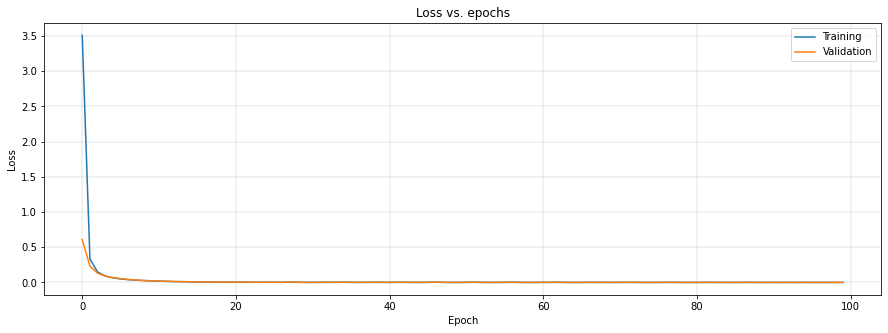

In [15]:
# Plot the training and validation loss
plt.figure(2,figsize=(15, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

### Check the validation error on the test set

In [16]:
evaluation_losses = model_invfft.evaluate(test_target,test_input,verbose=0)
print()
print(" ========= test dataset has mse loss : {} ".format(evaluation_losses[0]))


 ========= test dataset has mse loss : 0.0005913866916671395 


### Comparison of the CNN based IFFT signal with original random time series

Text(0, 0.5, 'Amplitude')

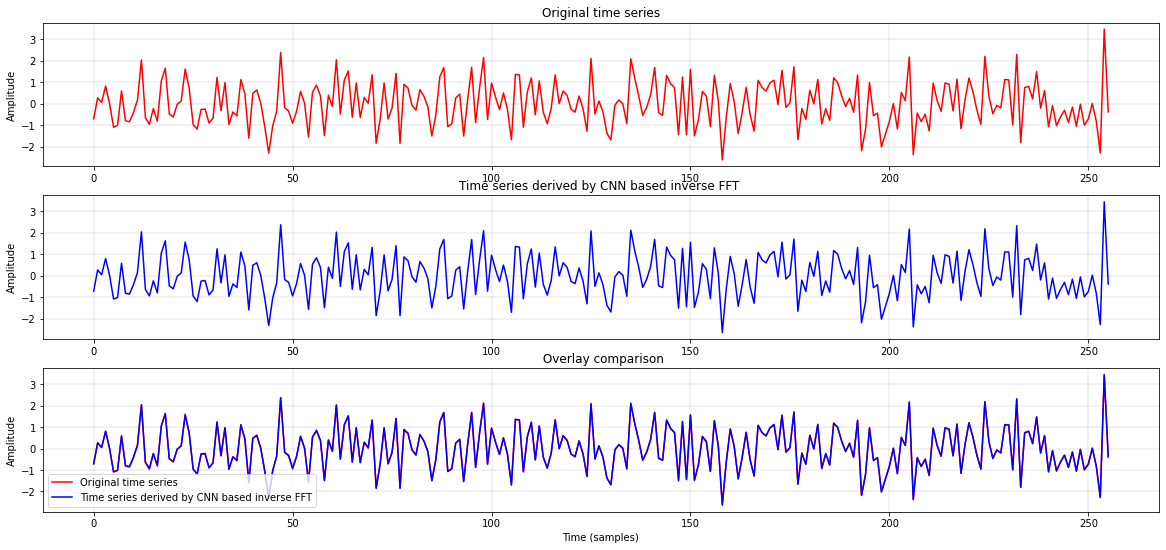

In [17]:
# prediction with trainned network

cnn_predictions = model_invfft.predict(test_target)
cnn_err         = cnn_predictions - test_input

# Comparison of the  CNN based IFFT signal with original signal on selected time series
qc_series_id = 10

plt.figure(figsize=(20, 9))
plt.subplot(311)
plt.plot(test_input[qc_series_id,:],'r')
plt.title('Original time series')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.ylabel('Amplitude')

plt.subplot(312)
plt.plot(cnn_predictions[qc_series_id,:],'b')
plt.title('Time series derived by CNN based inverse FFT ')
plt.grid(color='k', linestyle='-', linewidth=0.1)
# plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

plt.subplot(313)
plt.plot(test_input[qc_series_id,:],'r',label='Original time series')
plt.plot(cnn_predictions[qc_series_id,:],'b',label='Time series derived by CNN based inverse FFT')
plt.title(' Overlay comparison')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='lower left')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')


### Comparison of the CNN based IFFT signal with original synthetic time series

Text(0, 0.5, 'Amplitude')

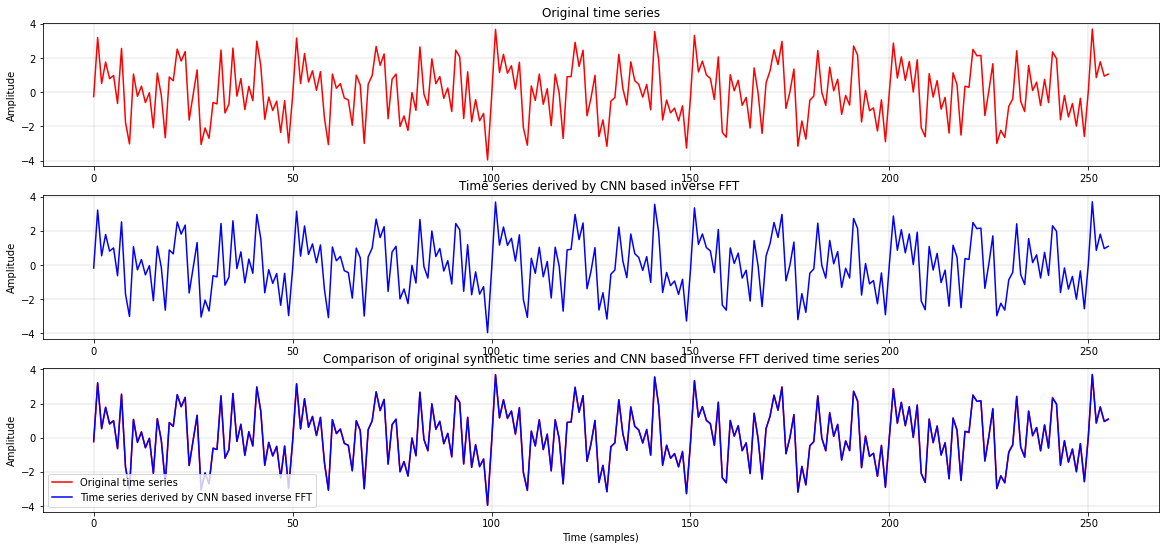

In [18]:
FFT_syn             = scipy.fftpack.fft(syn_data)

fft_syn_data_input  = np.zeros((1,length_series*2))
fft_syn_data_input[:,0::2] = FFT_syn.real
fft_syn_data_input[:,1::2] = FFT_syn.imag

dnn_predictions_syn = model_invfft.predict(fft_syn_data_input)


# plt.figure(figsize=(20, 9))
# plt.plot(syn_data,'r',label='Original time series')
# plt.plot(dnn_predictions_syn.flatten(),'b',label='Time series derived by CNN based inverse FFT')
# plt.title('Comparison of original synthetic time series and CNN based inverse FFT derived time series')
# plt.grid(color='k', linestyle='-', linewidth=0.1)
# plt.legend(loc='lower left')
# plt.xlabel('Time (samples)')
# plt.ylabel('Amplitude')

plt.figure(figsize=(20, 9))
plt.subplot(311)
plt.plot(syn_data,'r')
plt.title('Original time series')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.ylabel('Amplitude')

plt.subplot(312)
plt.plot(dnn_predictions_syn.flatten(),'b')
plt.title('Time series derived by CNN based inverse FFT ')
plt.grid(color='k', linestyle='-', linewidth=0.1)
# plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')

plt.subplot(313)
plt.plot(syn_data,'r',label='Original time series')
plt.plot(dnn_predictions_syn.flatten(),'b',label='Time series derived by CNN based inverse FFT')
plt.title('Comparison of original synthetic time series and CNN based inverse FFT derived time series')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.legend(loc='lower left')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')




The results show that the time series derived from CNN-based IFFT matches well with the original time series.

-------------------------------------------------------------
## *Summary* 
-------------------------------------------------------------


In the above numerical examples, we demonstrated that using a convolutional neural network to simulate the Fast Fourier Transform (FFT). By comparing the results derived by FFT, the demonstrated convolutional neural network approach shows a reasonable accuracy in simulating both the forward Fourier transform and inverse Fourier transform. It also shows the potential of using the neural network-based signal decomposition and reconstruction for the complex signal analysis.

-------------------------------------------------------------
## *Reference* 
-------------------------------------------------------------


- Geron, Aurelien, Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow
- Trevor Hastie, Robert Tibshirani and Jerome Friedman, The Elements of Statistical Learning- Data Mining, Inference, and Prediction, Springer 2008.
- Ian Goodfellow and Yoshua Bengio and Aaron Courville, Deep Learning, MIT Press, 2016